This notebook is split into 2 parts: Documentation and Data

The Documentation section includes details about the I-24 Motion Dataset, citations, references, as well as how it will be used in the notebook.

The Data section includes python code for transforming and visualizing the I-24 dataset

# Documentation

## Dataset Information

### Interstate-24 MOTION INCEPTION Dataset

- I-24 in the Nashville-Davidson County Metropolitan area, with coverage of approximately 4.2 miles
- Data recorded with 294 ultra-high definition camera, then converted to trajectory data anonymously using Artificial Intelligence (AI) trajectory algorithms developed by Vanderbilt University
- Includes 10 days of data, weekdays of Nov 21 - 25, 2022, and weekdays of Nov 28 - Dec 2, 2022

### References

Official Website: https://i24motion.org/

Official Article (pdf): https://arxiv.org/pdf/2301.11198

Github Repository: https://github.com/I24-MOTION

Dataset Documentation: https://github.com/I24-MOTION/I24M_documentation/blob/main/v1.x_I-24MOTION_data_documentation.pdf

Data Tutorial: https://github.com/I24-MOTION/data_tutorial

### Citation

Gloudemans, D., Wang, Y., Ji, J., Zachar, G., Barbour, W., Hall, E., Cebelak, M., Smith, L. and Work, D.B., 2023. I-24 MOTION: An instrument for freeway traffic science. Transportation Research Part C: Emerging Technologies, 155, p.104311.

## Usage

### Dataset Details

The I-24 MOTION INCEPTION dataset is organized as 2D trajectories, where each trajectory has an associated timestamp array, x-position array, and y-position array, along with other variables such as vehicle width and height. The full set of variables can be found on the on the [Github Documentation](https://github.com/I24-MOTION/I24M_documentation/blob/main/v1.x_I-24MOTION_data_documentation.pdf) 

For the purposes of having accurate lane delinations, only westbound data (direction = -1) will be used, as there are no provided lane delination approximations for eastbound data based on y-positions.

I-24 MOTION provided the approximate lateral ranges for lane delinations using the following y-position ranges: 
- 12-24: HOV Lane (lane 1)
- 24-36: lane 2
- 36-48: lane 3
- 48-60: lane 4

It is stated that "the lateral position is known to have deficiencies in v.10 of the data." ([Github Documentation](https://github.com/I24-MOTION/I24M_documentation/blob/main/v1.x_I-24MOTION_data_documentation.pdf))

Units: 
- Timestamp: seconds (unix time)
    - CST is 6 hours behind GMT (unix timestamp)
    - When converting I-24 INCEPTION dataset basetime, use 12:00 GMT on the date of recording
- Position: feet
    - "The positive x-direction is defined in the eastbound direction (direction of increasing post-mile as defined by the Interstate 24 mile markers), and x-coordinates are offset such that the x-coordinate for post-mile 60 corresponds exactly to 5280 × 60 = 316800 ft. (Other postmiles are approximately but not exactly located in this way (e.g. post-mile 61 ≈ 5280 × 61 = 322080 ft.)" ([Github Documentation](https://github.com/I24-MOTION/I24M_documentation/blob/main/v1.x_I-24MOTION_data_documentation.pdf))
    - This notebook utilizes a base spacial coordinate of 311520 (post-mile 59), as it is the first full mile-marker included in the recorded interval
    - For consistency in data partitioning code, any data past the 62.8 mile marker (roughly MM 63.4 - MM 63.6, corresponding with cameras 46-48) will be excluded
    - For simpler partitioning, the max x-position will be set to 331520 for more even partitioning
        - Mile marker 62.8 = 5280 ×  62.8 = 331584

### This Notebook

This notebook was written using:
- python 3.12
- pandas 2.2.2
- ijson 3.3.0
- matplotlib 3.8.4

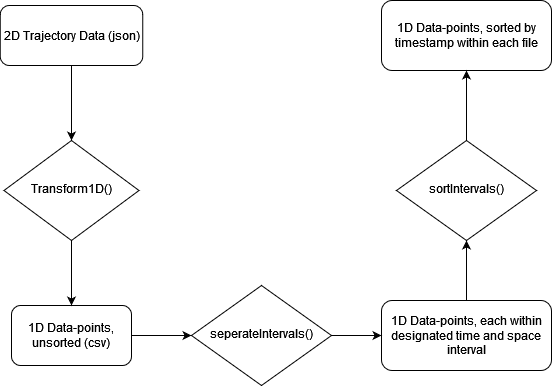

This notebook provides the code to transform a given set of 2D trajectory data in the I-24 format and split them into 1D data-points, which are organized into intervals of time and space based (this can be customized). 

The data processing consists of 3 steps, split into their own individual functions:
- Transform singular .json file of trajectory data (2D) into multiple .csv files with 1D data
- Each .csv consists of data points within a set interval, which are sorted based on timestamp
- Only westbound trajectories

The notebook also includes code for validating the transformation/parsing process and associated visualization on the resulting data:
- Testing valididty of parsing functions
- Visualizing partitioned data files
- Eliminating HOV lane, on-ramp

The notebook consists of precomputed variables for the 24 Nov. 2022 and 25 Nov. 2022 dataset, which the code was tested on:
- file_name ending with _post4.json refers to the 24 Nov. 2022 dataset
- file_name ending with _post5.json refers to the 25 Nov. 2022 dataset
    - Total trajectories in 11-25-2022: 1200505
    - Total Westbound trajectories: 652981 

# Transformation/Parsing

In [1]:
import os
import ijson
import csv
import pandas as pd
import matplotlib.pyplot as plt

### Function Declarations

In [2]:
def transform1D(root_dir: str, date: str, file_name: str):
    '''
    Separates 2D trajectory data into data points
    then store them in separate files for memory conservation
    
    inputs: 
        root_dir: directory where the I-24 json files are stored and where the transformed/partitioned files will be stored
        date: date when the data was recorded
        file_name: name of the I-24 data json file
    output: 
        new folder in root_dir, where the 1d data are stored in parts of ~1,000,000 data points
    '''

    # create directory, or empty directory if already exists
    unsorted_dir = os.path.join(root_dir, f'{date}_1D_split') 
    
    if os.path.exists(unsorted_dir):
        files = [file for file in os.listdir(unsorted_dir) if file.endswith('.csv')]
        for f in files:
            file_path = os.path.join(unsorted_dir, f)
            os.remove(file_path)
        print(f'Emptied folder at {unsorted_dir}')
    else:
        os.mkdir(unsorted_dir)
        print(f'Created folder at {unsorted_dir}')

    # open the file and parse through using ijson, which doesn't load the entire file into memory
    filepath = os.path.join(root_dir, file_name)
    with open(filepath, 'r') as input_file:
        parser = ijson.items(input_file, 'item')
        datapoints = []
        num = 1
        for doc in parser:
            # utilize only -1 (Westbound) trajectories, which have the lane estimates
            # utiliize only trajectories with an existing length
            # if the current trajectory doesn't fit these critiera, skip it
            if not ((int(doc['direction']) == -1) and (int(doc['length']) > 0)): continue

            id = doc['_id']['$oid']
            x_pos = doc['x_position']
            y_pos = doc['y_position']
            timestamp = doc['timestamp']
            length = len(timestamp)

            # separate individual data-points and calculate lane number
            for x, y, t, in zip(x_pos, y_pos, timestamp):
                lane_num = -1
                if 12<y<24: lane_num = 1
                if 24<y<36: lane_num = 2
                if 36<y<48: lane_num = 3
                if 48<y<60: lane_num = 4
                datapoints.append((id, t, x, lane_num))

            # dump to file if current datapoints in memory > 1 million (alleviate memory laod)
            if len(datapoints)>=1000000:
                datapoints = pd.DataFrame(datapoints, columns=['traj_id', 'timestamp', 'x_position', 'lane_num'])
                file_path = os.path.join(unsorted_dir, f'{date}_1D_part{num}.csv') 
                datapoints.to_csv(file_path, index=False)
                datapoints = []
                num+=1
                
        # dump remaining data
        datapoints = pd.DataFrame(datapoints, columns=['traj_id', 'timestamp', 'x_position', 'lane_num'])
        file_path = os.path.join(unsorted_dir, f'{date}_part{num}.csv') 
        datapoints.to_csv(file_path, index=False)
        print(f'Dumped 1D data at {unsorted_dir}, in {num} parts')

In [3]:
def separateIntervals(root_dir: str, date:str, min_time: int, max_time: int, time_interval: int, min_pos: int, max_pos: int, space_interval: int):
    '''
    Goes through each file of data points, 
    add datapoints to corresponding time interval

    input: 
        root_dir: directory where the I-24 json files are stored and where the transformed/partitioned files will be stored
        date: date when the data was recorded
        min_time: the starting time of the desired partition, in unix time (seconds)
        max_time: the ending time of the desired partition, in unix time (seconds)
        time_interval: the duration of each interval, in seconds
        min_pos: the minimum spacial position of the desired partition, in feet
        max_pos: the maximum spacial position of the desired partition, in feet
        space_interval: the distance of each interval, in feet
    output: 
        new folder in root_dir where data parts are merged into bigger files,
        each file contains only data starting from its interval timestamp, for the duration of (interval_duration) variable
    '''

    # create directory, or empty directory if already exists
    interval_dir = os.path.join(root_dir, f'{date}_interval_{time_interval}_{space_interval}')
    
    if os.path.exists(interval_dir):
        files = [file for file in os.listdir(interval_dir) if file.endswith('.csv')]
        for f in files:
            file_path = os.path.join(interval_dir, f)
            os.remove(file_path)
        print(f'Emptied folder at {interval_dir}')
    else:
        os.mkdir(interval_dir)
        print(f'Created folder at {interval_dir}')

    unsorted_dir = os.path.join(root_dir, f'{date}_1D_split')
    files_1d = [file for file in os.listdir(unsorted_dir) if file.endswith('.csv')]


    # for each unsorted file, go line by line
    # and add datapoint to respective time/space interval file
    for file_str in files_1d:
        unsorted_path = os.path.join(unsorted_dir, file_str)
        with open(unsorted_path, 'r') as unsorted_file:
            unsorted_csv = csv.reader(unsorted_file)
            # skip the first row (column names)
            next(unsorted_csv)

            for row in unsorted_csv:
                # traj_id,timestamp,x_position,lane_num
                time = float(row[1])
                pos = float(row[2])

                # skipping out of bounds data-points
                if not (min_time < time < max_time and min_pos < pos < max_pos): continue

                # calculate appropriate interval for insertion
                curr_time = (time - base_time) // time_interval
                curr_pos = (pos - min_pos) // space_interval 
                interval_path = os.path.join(interval_dir, f'{date}_{curr_time}_{curr_pos}.csv')

                # create new csv file if doesn't exist already
                if not os.path.exists(interval_path):
                    dataframe = pd.DataFrame(columns=['traj_id', 'timestamp', 'x_position', 'lane_num'])
                    dataframe.to_csv(interval_path, index=False)

                # write row to appropriate file based on interval    
                # use 'a' to add 
                with open(interval_path, 'a', newline='') as csvfile:
                    csv_writer = csv.writer(csvfile)
                    csv_writer.writerow(row)

    print(f'All files partitioned into intervals at {interval_dir}')

In [4]:
def sortIntervals(root_dir: str, date:str, time_interval: int, space_interval: int):
    '''
    Goes through each interval of datapoints,
    sorts by timestamp such that all data is sequential by timestamp

    Deletes original unsorted files 

    input: 
        root_dir: directory where the I-24 json files are stored and where the transformed/partitioned files will be stored
        date: date when the data was recorded
        time_interval: the duration of each interval, in seconds
        space_interval: the distance of each interval, in ft
    output:
        interval files within time/space domain, sorted by timestamp
        removes unsorted 1D datapoint files and directory
    '''
    
    interval_dir = os.path.join(root_dir, f'{date}_interval_{time_interval}_{space_interval}')
    interval_files = [file for file in os.listdir(interval_dir) if file.endswith('.csv')]

    # for each interval, sort intervals locally
    for interval in interval_files: 
        file_path = os.path.join(interval_dir, interval)
        interval_df = pd.read_csv(file_path)
        interval_df.sort_values('timestamp')
        interval_df.to_csv(file_path, index=False)
    print(f'Sorted all interval files at {interval_dir}')
    
    # delete the directory where data was originally split into 1D parts
    # unsorted_dir = os.path.join(root_dir, f'{date}_1D_split')
    # unsorted_files = [file for file in os.listdir(unsorted_dir) if file.endswith('.csv')]
    # for f in unsorted_files:
    #     file_path = os.path.join(unsorted_dir, f)
    #     os.remove(file_path)
    # os.rmdir(unsorted_dir) 
    # print(f'Deleted unsorted files and folder at {unsorted_dir}')

### Execution

In [5]:
# time when cameras started recording on 11/25/2022 at 6:00AM CST = 11/25/2022 at 12:00PM GMT
# with 11 hours of total data
# date = '11-25-2022'
# base_time =  1669377600
# end_time = base_time + 11*60*60
# file_name = '6380728cdd50d54aa5af0cf5__post5.json'

# time when cameras started recording on 11/24/2022 at 6:00AM CST = 11/24/2022 at 12:00PM GMT
# with 4 hours of total data
date = '11-24-2022'
file_name = '637f0d5f78f0cb97981425de__post4.json'
base_time = 1669291200
end_time = base_time + 4*60*60

min_time = base_time
max_time = base_time + 2*60*60
time_interval = 3600
min_pos = 311520
max_pos = 331520
space_interval = 2000

root_dir = 'C:\\Users\\2003C\\Desktop\\Jupyter\\Data'

In [6]:
transform1D(root_dir, date, file_name)
separateIntervals(root_dir, date, min_time, max_time, time_interval, min_pos, max_pos, space_interval)
sortIntervals(root_dir, date, time_interval, space_interval)

Created folder at C:\Users\2003C\Desktop\Jupyter\Data\11-24-2022_interval_3600_2000
All files partitioned into intervals at C:\Users\2003C\Desktop\Jupyter\Data\11-24-2022_interval_3600_2000
Sorted all interval files at C:\Users\2003C\Desktop\Jupyter\Data\11-24-2022_interval_3600_2000


# Testing

In [7]:
root_dir = 'C:\\Users\\2003C\\Desktop\\Jupyter\\Data'

date = '11-24-2022'
file_name = '637f0d5f78f0cb97981425de__post4.json'
base_time = 1669291200
end_time = base_time + 4*60*60

min_time = base_time
max_time = base_time + 2*60*60
time_interval = 3600
min_pos = 311520
max_pos = 331520
space_interval = 2000

interval_dir = os.path.join(root_dir, f'{date}_interval_{time_interval}_{space_interval}')
interval_files = [file for file in os.listdir(interval_dir) if file.endswith('.csv')]

unsorted_dir = os.path.join(root_dir, f'{date}_1D_split')
unsorted_files = [file for file in os.listdir(unsorted_dir) if file.endswith('.csv')]

### Pre-sorted Data

In [40]:
# length of each trajectory is the same in time, x, y
filepath = os.path.join(root_dir, file_name)
with open(filepath, 'r') as input_file:
    parser = ijson.items(input_file, 'item')
    datapoints = []
    num = 1
    for doc in parser:
        if not ((int(doc['direction']) == -1) and (int(doc['length']) > 0)): continue

        x_pos = doc['x_position']
        y_pos = doc['y_position']
        timestamp = doc['timestamp']
        
        if len(x_pos) != len(y_pos) != len(timestamp):
            print(f'Non-match length in file {filepath}')
            break
print('All trajectories have equivalent lengths for time, x_pos, y_pos')

All trajectories have equivalent lengths for time, x_pos, y_pos


lane_num
-1     1626610
 1     6271500
 2    11613329
 3    10440527
 4     6869105
Name: count, dtype: int64


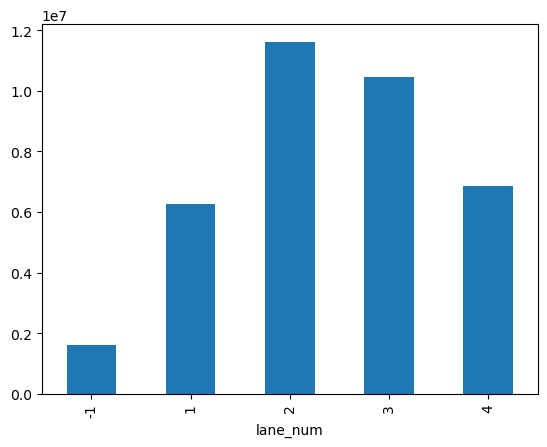

In [65]:
lane_num_counts = []
for f in unsorted_files:
    file_path = os.path.join(unsorted_dir, f)
    df = pd.read_csv(file_path)
    lane_num_counts.append( df['lane_num'].value_counts() )

merged_counts = pd.concat(lane_num_counts).groupby(level=0).sum()
merged_counts.plot(kind='bar')
print(merged_counts)

### Partitioned Data

In [26]:
misplaced = []
interavl_df = None

for interval in interval_files:
    file_path = os.path.join(interval_dir, interval)
    interval_df = pd.read_csv(file_path)
    interval_str = interval.split('_')
    
    interval_base_time = float(interval_str[1])*time_interval + base_time
    interval_max_time = interval_base_time + time_interval

    interval_base_pos = float(interval_str[2][:len(interval_str[2])-4])*space_interval + min_pos
    interval_max_pos = interval_base_pos + space_interval

    # print(interval_base_time, interval_max_time)
    # print(interval_base_pos, interval_max_pos)

    if not interval_base_time <= interval_df['timestamp'].min() and interval_df['timestamp'].max() <= interval_max_time:
        misplaced.append(interval)
        print(interval, interval_base_time, interval_df['timestamp'].min(), interval_df['timestamp'].max(), interval_max_time)
        
    elif not interval_base_pos <= interval_df['x_position'].min() and interval_df['x_position'].max() <= interval_max_pos:
        misplaced.append(interval)
        print(interval, interval_base_pos, interval_df['x_position'].min(), interval_df['x_position'].max(), interval_max_pos)

print(misplaced)

[]


In [27]:
lane_num_counts = []
for interval in interval_files:
    file_path = os.path.join(interval_dir, interval)
    interval_df = pd.read_csv(file_path)
    interval_str = interval.split('_')
    
    time_min = float(interval_str[1])
    space_min = float(interval_str[2][:len(interval_str[2])-4])

    lane_num_counts.append( (time_min, space_min, interval_df['lane_num'].value_counts()) )

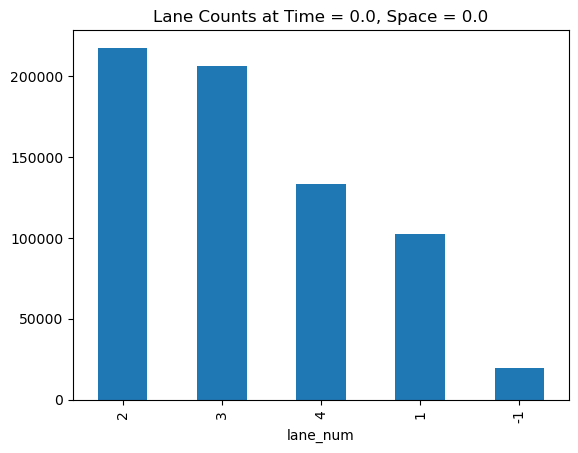

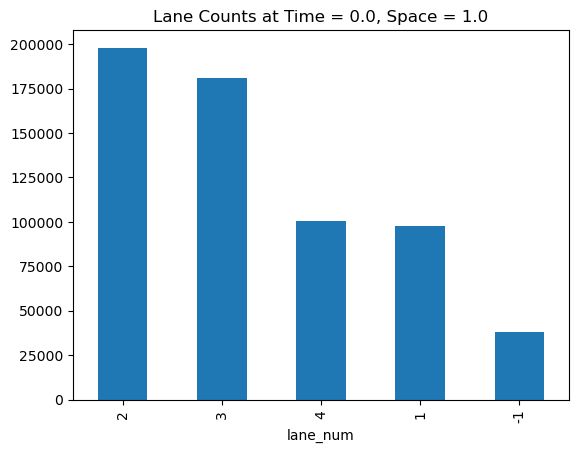

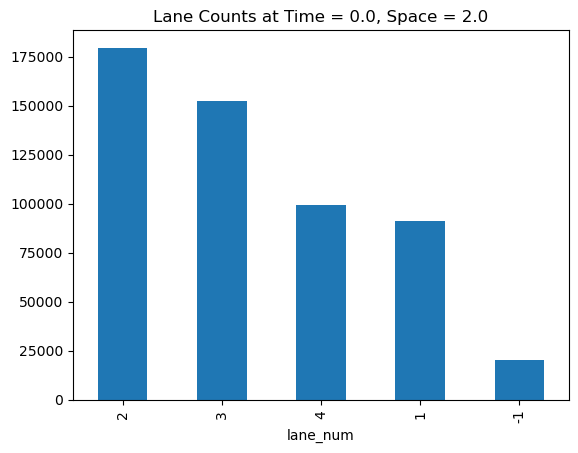

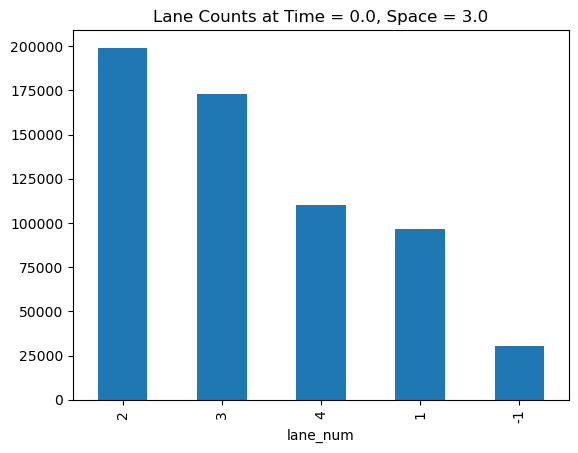

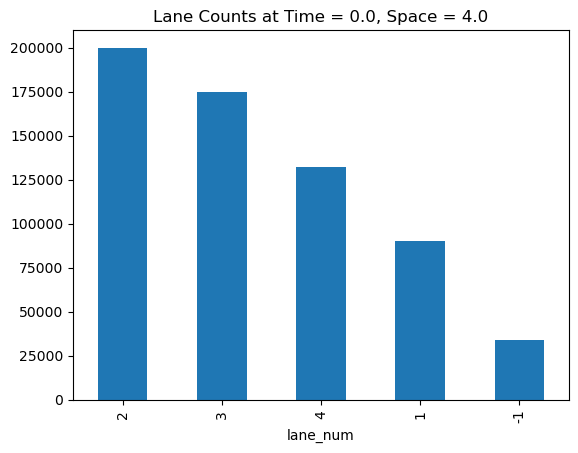

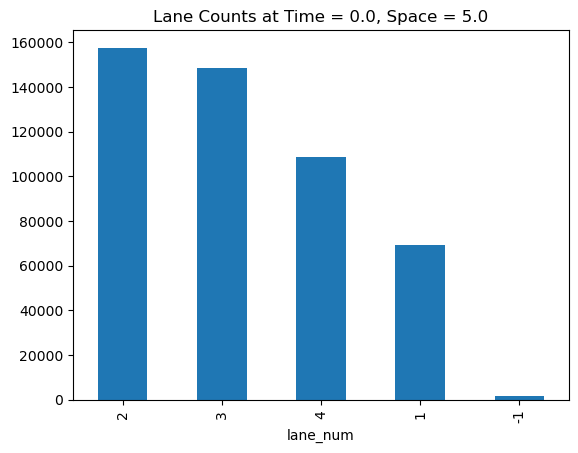

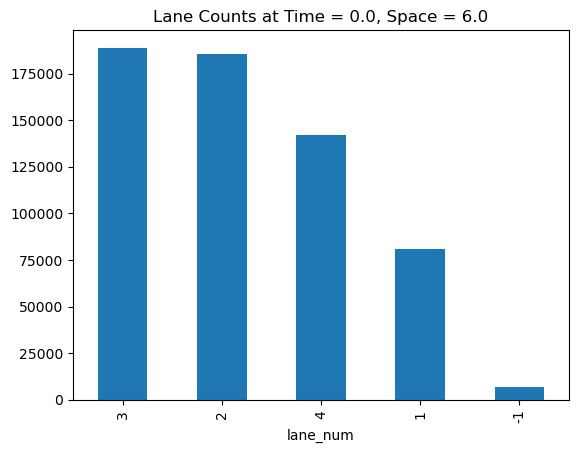

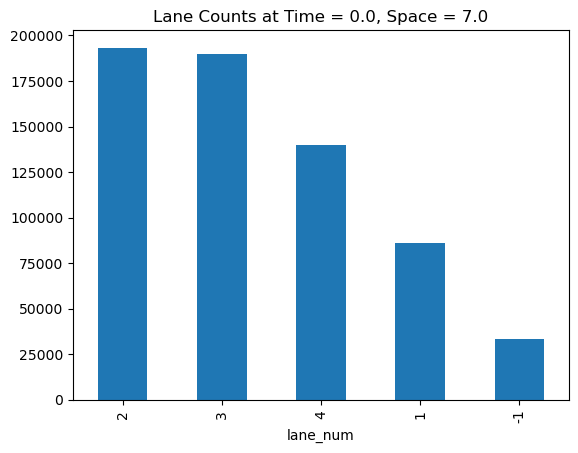

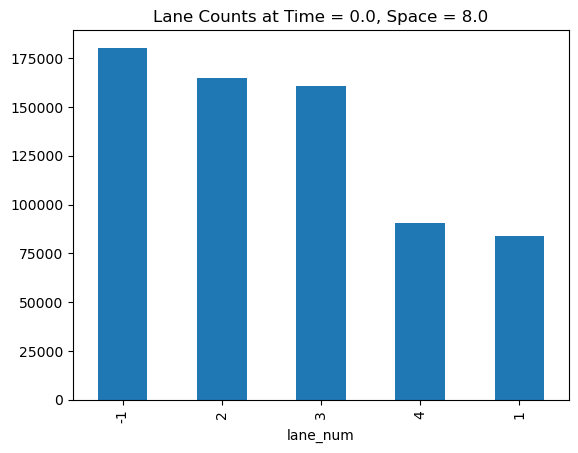

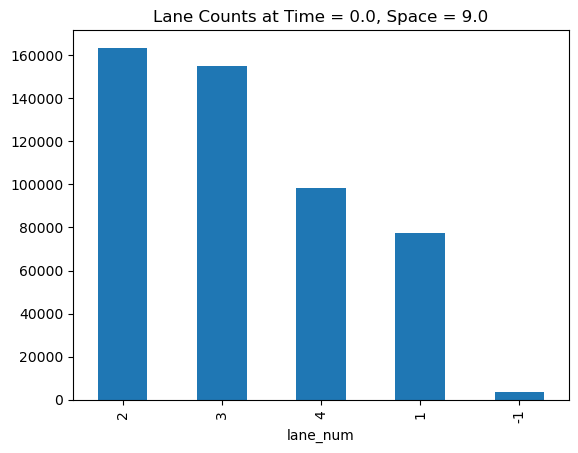

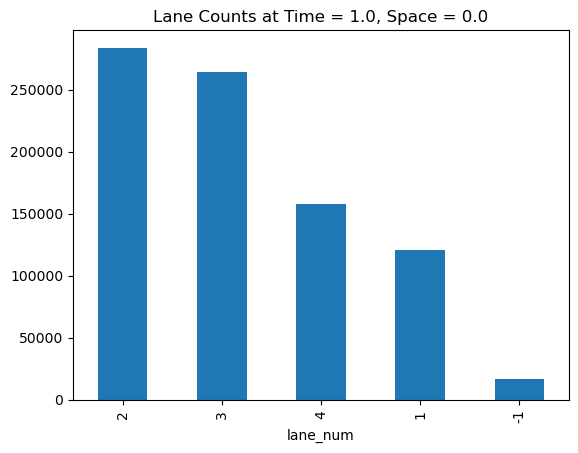

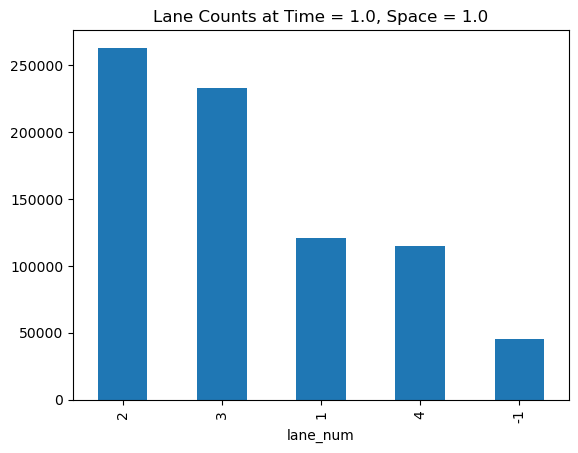

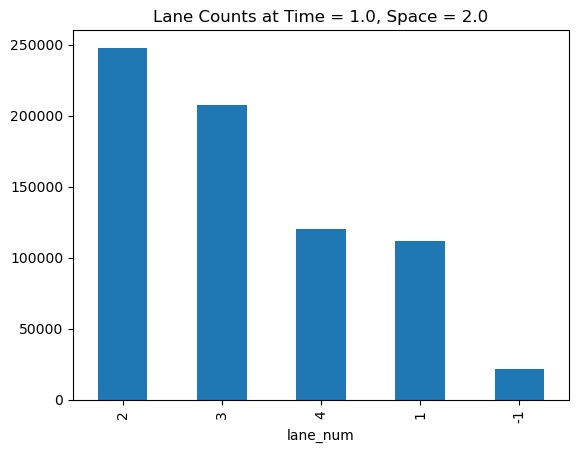

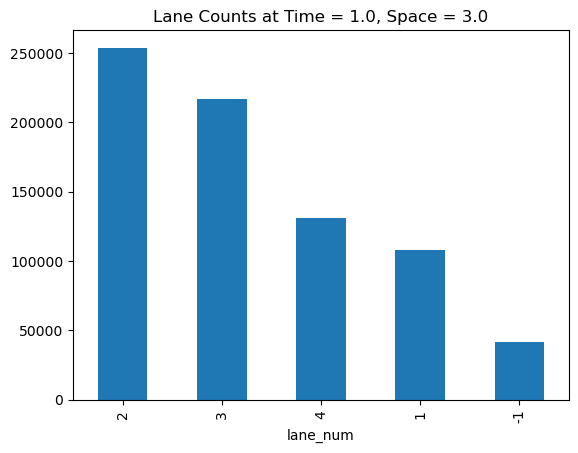

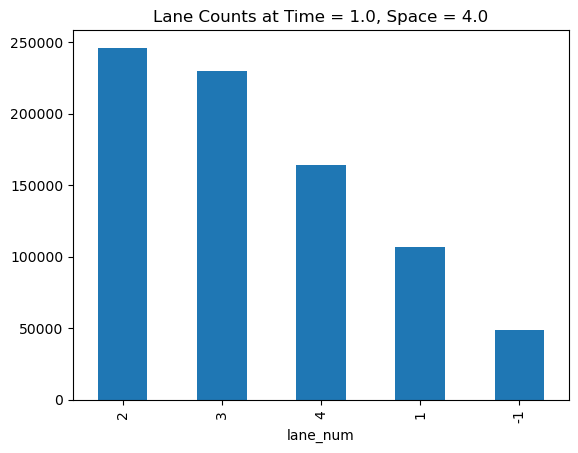

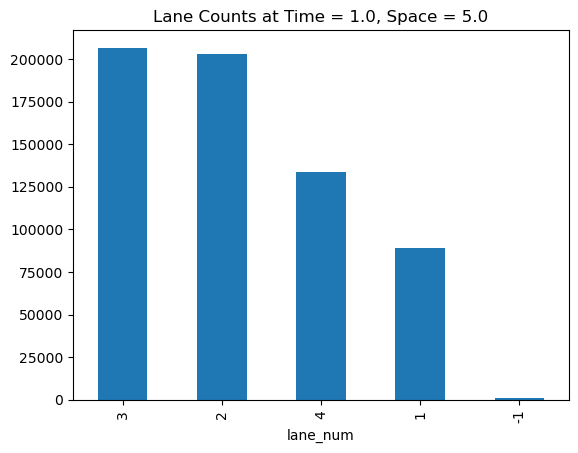

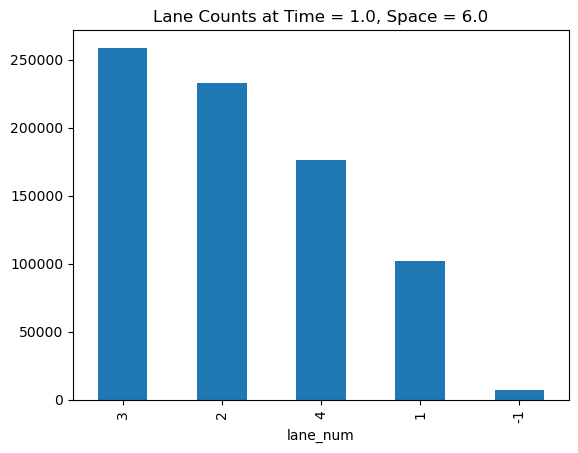

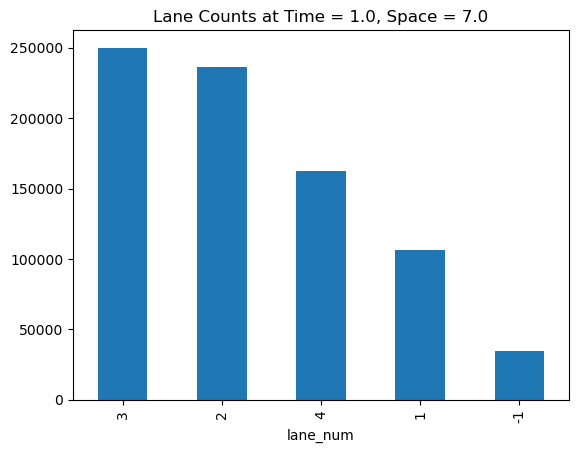

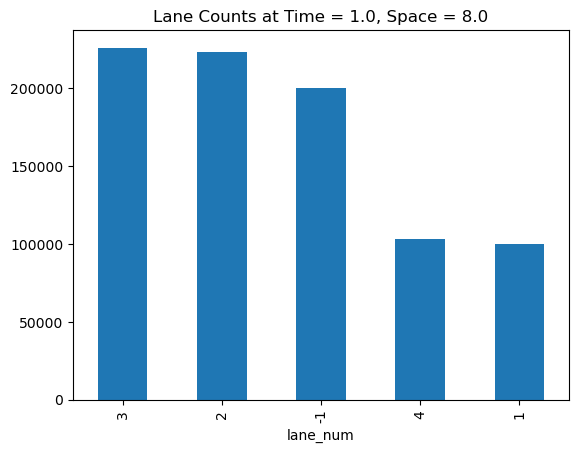

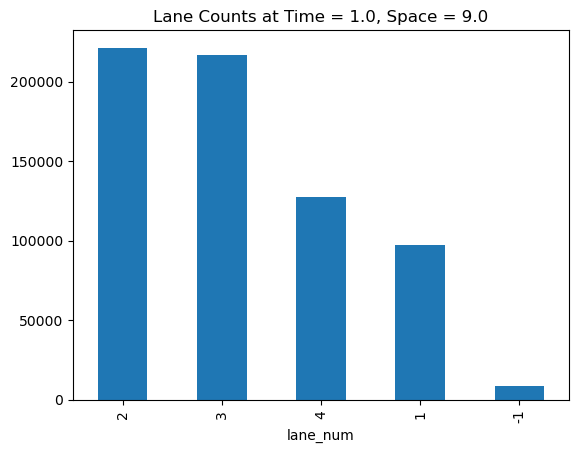

In [28]:
for c in lane_num_counts:
    time, space, count = c
    ax = count.plot(kind='bar')
    ax.set_title(f'Lane Counts at Time = {time}, Space = {space}')
    plt.show()

# Auxillary

This part of the code is here for reference and miscellaneous testing only. 

All functional aspects, testing, and visualization are located in prior parts of the notebook.

### CSV

In [35]:
# testing how to insert into csv correctly
test_path = os.path.join(root_dir, 'test.csv')
test_df = pd.DataFrame(columns=['traj_id', 'timestamp', 'x_position', 'lane_num'])
test_df.to_csv(test, index=False)

confirm_df = []

for file_str in unsorted_files: 
    unsorted_path = os.path.join(unsorted_dir, file_str)

    with open(unsorted_path, 'r') as unsorted_file:
        unsorted_csv = csv.reader(unsorted_file)
        # skip the first row (column names)
        next(unsorted_csv)

        for row in unsorted_csv:
            # traj_id,timestamp,x_position,lane_num
            confirm_df.append(row)
            
            with open(test, 'a', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow(row)
            break

confirm_df = pd.DataFrame(confirm_df,columns=['traj_id', 'timestamp', 'x_position', 'lane_num'])
confirm_df

,traj_id,timestamp,x_position,lane_num
0,6389327c350d21d4135b4ca6,1669291200.5,314433.3097977172,2
1,63895842a316a96d3f7b613d,1669295921.5,327847.3397862911,2
2,638958aa29368a666bf3a21c,1669296398.3000004,324964.2345575991,3
3,63895bbd350d21d4135b6faf,1669296803.9,314489.5638219099,3
4,63895f3d05f9baa10e5cb250,1669297204.8000004,331550.4698015513,3
5,63896a0937c0e70748897da1,1669297640.7,316748.594145372,1
6,63896a81a316a96d3f7b79f3,1669298049.9,328585.78408630146,-1
7,638969052ed98f4f631719ce,1669298404.7,321959.56444115826,2
8,6389705d2dd8b91c18c33ae4,1669298824.8000004,318090.7585393971,4
9,63896ee029368a666bf3c52d,1669299202.4,327561.51028220734,4


In [36]:
test_df = pd.read_csv(test)
test_df

,traj_id,timestamp,x_position,lane_num
0,6389327c350d21d4135b4ca6,1.669291e+09,314433.309798,2
1,63895842a316a96d3f7b613d,1.669296e+09,327847.339786,2
2,638958aa29368a666bf3a21c,1.669296e+09,324964.234558,3
3,63895bbd350d21d4135b6faf,1.669297e+09,314489.563822,3
4,63895f3d05f9baa10e5cb250,1.669297e+09,331550.469802,3
5,63896a0937c0e70748897da1,1.669298e+09,316748.594145,1
6,63896a81a316a96d3f7b79f3,1.669298e+09,328585.784086,-1
7,638969052ed98f4f631719ce,1.669298e+09,321959.564441,2
8,6389705d2dd8b91c18c33ae4,1.669299e+09,318090.758539,4
9,63896ee029368a666bf3c52d,1.669299e+09,327561.510282,4


In [38]:
print(test_df.values[0])

['6389327c350d21d4135b4ca6' 1669291200.5 314433.3097977172 2]
